In [34]:
import ugradio
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy import signal as sig
from scipy.stats import norm
from scipy.optimize import curve_fit

In [35]:
# Consistent Plot Params
titleSize = 13
axisSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)

In [36]:
# Data Extraction Helper Funcs
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab2Data\\" + folder
    raw_data = np.load(prefix + filename)
    return raw_data

def getDataBlocks(data, num_blocks=None, window=None):
    if not window:
        window = len(data['time_data'][1])
    if not num_blocks:
        num_blocks = len(data['time_data']) - 1
    
    new_data = np.zeros((num_blocks, window), dtype=complex)
    for i, block in enumerate(data['time_data'][1:num_blocks+1]):
        real = block[:window, 0]
        imag = block[:window, 1]
        new_data[i] = normalize(real + (1j * imag))
        #new_data[i] = real + (1j * imag)
    return new_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getSampleRate(data):
    return data['sample_rate']

def getGain(data):
    return data['gain']

def getUTC(data):
    return data['utc']

def getJulianDate(data):
    return data['jd']

def windowData(data):
    return data[:]

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getTimes(N, sample_rate=3.1e6):
    return [i / sample_rate for i in range(0, N)]

times = [i / 1e3 for i in range(0, 1024)]

In [37]:
# Extracting Data

# 6.2.1
folder = "Section6_2\\6_2_1\\"
#data_rf_off_test = extractRawData(folder, "rf_off_test.npz")
#data_rf_on_test = extractRawData(folder, "rf_on_test.npz")


# 6.2.2
folder = "Section6_2\\6_2_2\\"
data_LSB = extractRawData(folder, "LSB_10000.npz")
data_USB = extractRawData(folder, "USB_10000.npz")


# 6.2.3
folder = "Section6_2\\6_2_3\\"
data_coldsky = extractRawData(folder, "Coldsky_10000.npz")
data_humans = extractRawData(folder, "Humanbody_10000.npz")


# 8
folder = "Section8\\"
data_LSB_aimed = extractRawData(folder, "LSB.npz")
data_USB_aimed = extractRawData(folder, "USB.npz")


# 9.2
folder = "Section9\\Section9_2\\"
data_100mV_short = extractRawData(folder, "voltcount_100mV.npz")
data_100mV_long = extractRawData(folder, "voltcount_100mV_long_cable.npz")
data_200mV_short = extractRawData(folder, "voltcount_200mV.npz")
data_200mV_long = extractRawData(folder, "voltcount_200mV_long_cable.npz")
data_300mV_short = extractRawData(folder, "voltcount_300mV.npz")
data_300mV_long = extractRawData(folder, "voltcount_300mV_long_cable.npz")
data_400mV_short = extractRawData(folder, "voltcount_400mV.npz")
data_400mV_long = extractRawData(folder, "voltcount_400mV_long_cable.npz")
data_500mV_short = extractRawData(folder, "voltcount_500mV.npz")
data_500mV_long = extractRawData(folder, "voltcount_500mV_long_cable.npz")


# 9.3
folder = "Section9\\Section9_3\\"
data_bandpass_100mV = extractRawData(folder, "bandpass_100mV.npz")
data_bandpass_200mV = extractRawData(folder, "bandpass_200mV.npz")
data_bandpass_300mV = extractRawData(folder, "bandpass_300mV.npz")
data_bandpass_400mV = extractRawData(folder, "bandpass_400mV.npz")
data_bandpass_500mV = extractRawData(folder, "bandpass_500mV.npz")

In [38]:
def graphOverlayTimeData(datasets, labels, signal, sample_rate=3.1e6, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    times = getTimes(len(datasets[0]), sample_rate)

    for i, data in enumerate(datasets):
        plt.plot(times, data, label=labels[i])
        plt.scatter(times, data, s=10)

    plt.xlabel("Time (ms)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylabel("Voltage Counts (Arbitrary Scale)", fontsize=axisSize)
    plt.title(f"{signal} Signals w/ 3.1 MHz Sample Rate", size=titleSize)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [39]:
def graphOverlayPowerSpectra(datasets, sample_rates, labels, signal, multiple=True, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    mid = len(datasets[0]) // 2

    for i, data in enumerate(datasets):
        a = 1 if i == 0 else 0.1
        factor = 1
        c = "red" if i == 0 else "blue"
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rates[i]))

        power_spectrum = 2 * (abs(fft_data_shifted) ** 2)
        print(len(power_spectrum))
        plt.plot(freq_bins / 1e3, power_spectrum / factor, label=f"{labels[i]}", alpha=1, color=c)

    plt.xlim(xlim)
    plt.xlabel("Frequency (kHz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"One Sided Power Spectra of {signal} Signals", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [40]:
def graphAvgPowerSpectra(USB_blocks, LSB_blocks, sample_rate, center_freqs, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    avg_power_USB = np.zeros(len(USB_blocks[0]))
    avg_power_LSB = np.zeros(len(USB_blocks[0]))

    for data in USB_blocks:
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        avg_power_USB += (abs(fft_data_shifted) ** 2)
        
    for data in LSB_blocks:
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        avg_power_LSB += (abs(fft_data_shifted) ** 2)
        
    avg_power_USB /= len(USB_blocks)
    avg_power_LSB /= len(LSB_blocks)

    factor = 150
    plt.plot(freq_bins / 1e3, (avg_power_USB - avg_power_LSB) / factor, label=f"USB (center freq {center_freqs[0]})", alpha=1)
    plt.plot(freq_bins / 1e3, (avg_power_LSB - avg_power_USB) / factor, label = f"LSB (center freq {center_freqs[1]})", alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (kHz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra of USB and LSB ", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
def graphAvgPowerSpectraLines(USB_blocks, LSB_blocks, sample_rate, xlim=None, ylim=None):
    fig, axs = plt.subplots(1, 2, figsize=graphSizeDouble)

    power_on = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    power_off = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    mid = len(USB_blocks[0]) // 2

    for i, data in enumerate(LSB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[i][:mid] = (abs(fft_data_shifted) ** 2)[:mid]
        power_off[i][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        
    for j, data in enumerate(USB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[j][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        power_off[j][:mid] = (abs(fft_data_shifted) ** 2)[:mid]

    avg_on_mean = np.mean(power_on, axis=0)
    avg_on_median = np.median(power_on, axis=0)
    avg_off_mean = np.mean(power_off, axis=0)
    avg_off_median = np.median(power_off, axis=0)  

    avg_on_mean[len(avg_on_mean)//2] = avg_on_mean[len(avg_on_mean)//2 - 1]
    avg_on_mean[len(avg_on_mean)//2 + 1] = avg_on_mean[len(avg_on_mean)//2 + 2]

    avg_off_mean[len(avg_off_mean)//2] = avg_off_mean[len(avg_off_mean)//2 - 1]
    avg_off_mean[len(avg_off_mean)//2 + 1] = avg_off_mean[len(avg_off_mean)//2 + 2]

    tau_line_mean = avg_on_mean / avg_off_mean
    tau_line_median = avg_on_median / avg_off_median

    factor = 150
    axs[0].plot(freq_bins / 1e3, avg_on_mean / factor, label="on-line w/ np.mean()", alpha=1)
    axs[1].plot(freq_bins / 1e3, avg_on_median / factor, label="on-line w/ np.median()", alpha=1)
    axs[0].plot(freq_bins / 1e3, avg_off_mean / factor, label="off-line w/ np.mean()", alpha=0.8)
    axs[1].plot(freq_bins / 1e3, avg_off_median / factor, label="off-line w/ np.median()", alpha=0.8)

    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)

    axs[0].set_xlabel("Frequency (kHz)", fontsize=axisSize)
    axs[1].set_xlabel("Frequency (kHz)", fontsize=axisSize)
    axs[0].set_ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    axs[1].set_ylabel("Power (Arbitary Scale)", fontsize=axisSize)

    axs[0].set_title(f"On-/Off-line Power Spectra from USB and LSB ", size=titleSize)
    axs[1].set_title(f"On-/Off-line Power Spectra from USB and LSB ", size=titleSize)

    axs[0].legend()
    axs[1].legend()
    axs[0].grid(True)
    axs[1].grid(True)
    plt.show()

    return tau_line_mean, tau_line_median

def graphAvgPowerSpectraLinesSingle(USB_blocks, LSB_blocks, sample_rate, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    power_on = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    power_off = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    mid = len(USB_blocks[0]) // 2

    for i, data in enumerate(LSB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[i][:mid] = (abs(fft_data_shifted) ** 2)[:mid]
        power_off[i][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        
    for j, data in enumerate(USB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[j][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        power_off[j][:mid] = (abs(fft_data_shifted) ** 2)[:mid]

    avg_on_mean = np.mean(power_on, axis=0)
    avg_on_median = np.median(power_on, axis=0)
    avg_off_mean = np.mean(power_off, axis=0)
    avg_off_median = np.median(power_off, axis=0)

    avg_on_mean[len(avg_on_mean)//2] = avg_on_mean[len(avg_on_mean)//2 - 1]
    avg_on_mean[len(avg_on_mean)//2 + 1] = avg_on_mean[len(avg_on_mean)//2 + 2]

    avg_off_mean[len(avg_off_mean)//2] = avg_off_mean[len(avg_off_mean)//2 - 1]
    avg_off_mean[len(avg_off_mean)//2 + 1] = avg_off_mean[len(avg_off_mean)//2 + 2]

    tau_line_mean = avg_on_mean / avg_off_mean
    tau_line_median = avg_on_median / avg_off_median
    factor = 150

    plt.plot(freq_bins / 1e6, avg_on_mean / factor, label="on-line", alpha=1)
    plt.plot(freq_bins / 1e6, avg_off_mean / factor, label="off-line", alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (Arbitrary Scale)")
    plt.title(f"On-/Off-line Power Spectra versus IF Frequency ", size=titleSize)
    plt.legend()
    plt.grid()
    plt.show()

    return tau_line_mean, tau_line_median

def graphPowerSpectraRF(USB_blocks, LSB_blocks, sample_rate, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    power_LSB = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    power_USB = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    mid = len(USB_blocks[0]) // 2
    freq_bins = fftshift(fftfreq(len(USB_blocks[0]), d=1/sample_rate))

    for i, data in enumerate(LSB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        power_LSB[i] = (abs(fft_data_shifted) ** 2)

    for i, data in enumerate(USB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        power_USB[i] = (abs(fft_data_shifted) ** 2)

    avg_LSB_mean = np.mean(power_LSB, axis=0)
    avg_USB_mean = np.mean(power_USB, axis=0)

    avg_LSB_mean[len(avg_LSB_mean)//2] = avg_LSB_mean[len(avg_LSB_mean)//2 - 1]
    avg_LSB_mean[len(avg_LSB_mean)//2 + 1] = avg_LSB_mean[len(avg_LSB_mean)//2 + 2]

    avg_USB_mean[len(avg_USB_mean)//2] = avg_USB_mean[len(avg_USB_mean)//2 - 1]
    avg_USB_mean[len(avg_USB_mean)//2 + 1] = avg_USB_mean[len(avg_USB_mean)//2 + 2]

    factor = 150
    plt.plot((freq_bins + 1421e6) / 1e6, avg_LSB_mean / factor, label="LSB", alpha=1)
    plt.plot((freq_bins + 1420e6)/ 1e6, avg_USB_mean / factor, label="USB", alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (Arbitrary Scale)")
    plt.title(f"On-/Off-line Power Spectra versus RF Frequency ", size=titleSize)
    plt.legend()
    plt.grid()
    plt.show()

In [42]:
def graphSingleGaussianHistogram(data, sample_rate, signals, num_bins):
    # Check block size first
    plt.figure(figsize=graphSizeSingle)

    bins = np.linspace(min(data), max(data), num_bins)
    plt.hist(data, bins=num_bins, density=True, alpha=1, label="Sampled Data")

    gaussian_fit = norm.pdf(bins, np.mean(data), np.std(data))
    plt.plot(bins, gaussian_fit, 'r--', linewidth=5, label="Gaussian Fit")

    plt.xlabel("Measured Voltage / Counts", fontsize=axisSize)
    plt.ylabel("Probability Density", fontsize=axisSize)
    plt.title(f"Noise of {signals} Signal w/ {sample_rate} & {num_bins} bins", size=titleSize)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [43]:
def graphTauLines(tau_mean, tau_median, sample_rate, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    freq_bins = fftshift(fftfreq(len(tau_mean), d=1/sample_rate))

    plt.plot(freq_bins / 1e6, tau_mean, label=r"$\tau_{line}$ (mean)")
    plt.plot(freq_bins / 1e6, tau_median, label=r"$\tau_{line}$ (median)", alpha=0.7)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Ratio (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Line Shape of On-Line / Off-Line Ratio versus IF Frequency", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
def computeCalibratedGain(coldsky, humans, T_cal=300):
    N = len(coldsky[0])
    
    avg_coldsky = np.mean(abs(fft(coldsky, axis=1) / N) ** 2, axis=0)
    avg_humans = np.mean(abs(fft(humans, axis=1) / N) ** 2, axis=0)

    avg_coldsky[len(avg_coldsky)//2] = avg_coldsky[len(avg_coldsky)//2 - 1]
    avg_coldsky[len(avg_coldsky)//2 + 1] = avg_coldsky[len(avg_coldsky)//2 + 2]

    avg_humans[len(avg_humans)//2] = avg_humans[len(avg_humans)//2 - 1]
    avg_humans[len(avg_humans)//2 + 1] = avg_humans[len(avg_humans)//2 + 2]

    bottom_sum = np.sum(avg_humans - avg_coldsky)
    coldsky_sum = np.sum(avg_coldsky)

    return (T_cal * coldsky_sum) / bottom_sum

In [45]:
def gaussian(X, amp, mean, stddev):
    return amp * np.exp(-((X - mean) ** 2) / (2 * stddev ** 2))

def bimodal_gaussian(X, amp1, mean1, stddev1, amp2, mean2, stddev2):
    return (amp1 * np.exp(-((X - mean1) ** 2) / (2 * stddev1 ** 2)) + amp2 * np.exp(-((X - mean2) ** 2) / (2 * stddev2 ** 2)))

def fit_gaussians(freq_bins, T, guess1=[41, 1420.32, 0.05], guess2=[20, 1420.45, 0.07], doppler=False):
    if doppler: 
        peak1_mask = (freq_bins > -80000) & (freq_bins < 0)
        peak2_mask = (freq_bins > 0) & (freq_bins < 50000)
    else:
        peak1_mask = (freq_bins > 1420.25) & (freq_bins < 1420.45)
        peak2_mask = (freq_bins > 1420.45) & (freq_bins < 1420.8)

    #print(freq_bins)
    #print(peak1_mask)
    # [amplitude, center, width]
    gaussian1, _ = curve_fit(gaussian, freq_bins[peak1_mask], T[peak1_mask], p0=guess1)
    gaussian2, _ = curve_fit(gaussian, freq_bins[peak2_mask], T[peak2_mask], p0=guess2)
    bimodal, _ = curve_fit(bimodal_gaussian, freq_bins, T, p0=guess1+guess2)
    
    return gaussian1, gaussian2, bimodal

def graphCalibratedPolyFitGaussian(T, xlim=None, ylim=None, IF=False):
    plt.figure(figsize=graphSizeSingle)

    clipped_T = T[len(T)//2:]
    clipped_T[0] = clipped_T[1]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))
    
    if IF:
        freq_bins -= 1420.405
        type = "IF"
    else:
        type = "RF"
    
    mask_offline = ((freq_bins < 1420.25) | (freq_bins > 1420.8))
    freq_offline = freq_bins[mask_offline]
    T_offline = clipped_T[mask_offline]
    poly_coeffs = np.polyfit(freq_offline, T_offline, 3) 
    poly_baseline = np.polyval(poly_coeffs, freq_bins)
    corrected_spectrum = clipped_T - poly_baseline
    
    gaussian1, gaussian2, bimodal = fit_gaussians(freq_bins, corrected_spectrum)
    print("[amplitude, center, width]")
    print(f"gaussian1 params = {gaussian1}")
    print(f"gaussian2 params = {gaussian2}")
    fitted_g1 = gaussian(freq_bins, *gaussian1)
    fitted_g2 = gaussian(freq_bins, *gaussian2)
    fitted_bimodal = bimodal_gaussian(freq_bins, *bimodal)

    plt.plot(freq_bins, corrected_spectrum, label='Corrected Spectrum', alpha=0.7)
    plt.plot(freq_bins, fitted_g1, label='Gaussian Fit 1', linestyle='dashed', linewidth=3)
    plt.plot(freq_bins, fitted_g2, label='Gaussian Fit 2', linestyle='dashed', linewidth=3, color="red")
    plt.plot(freq_bins, fitted_bimodal, label='Bimodal Gaussian Fit', linestyle='dashed', linewidth=3)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    plt.title(f"Calibrated T Spectrum versus {type} Frequency w/ Baseline Polyfit & Gaussian Fits", size=titleSize)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def graphCalibratedT(T, xlim=None, ylim=None, IF=False):
    plt.figure(figsize=graphSizeSingle)

    clipped_T = T[len(T)//2:]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))

    if IF:
        freq_bins -= 1420.405
        type = "IF"
    else:
        type = "RF"

    plt.plot(freq_bins, clipped_T)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    plt.title(f"Calibrated T Spectrum versus {type} Frequency", size=titleSize)
    plt.grid()
    plt.show()

def graphCalibratedTDoppler(T, correction=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    c = 2.997e8

    clipped_T = T[len(T)//2:-10]
    clipped_T[0] = clipped_T[1]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))
    naive_v = (c * (-(freq_bins - 1420.405) / 1420.405))
    if correction:
        corr_v = (c * (-(freq_bins - 1420.405) / 1420.405)) - correction
        mask = ((corr_v < -60000) | (corr_v > 50000))
        poly_coeffs = np.polyfit(corr_v[mask], clipped_T[mask], 3)
        poly_baseline_c = np.polyval(poly_coeffs, corr_v)
    
    mask = ((naive_v < -80000) | (naive_v > 40000))
    poly_coeffs = np.polyfit(naive_v[mask], clipped_T[mask], 3)
    poly_baseline = np.polyval(poly_coeffs, naive_v)
    
    plt.plot(naive_v / 1e3, clipped_T - poly_baseline, label="Observed Doppler Velocities")

    if correction:
        plt.plot(corr_v / 1e3, clipped_T - poly_baseline_c, label="Corrected to LSR", alpha=0.7)
        
    # [amplitude, center, width]
    guess1, guess2 = [20, -25000, 30000], [40, 20000, 20000]    
    gaussian1, gaussian2, bimodal = fit_gaussians(corr_v, clipped_T - poly_baseline_c, guess1, guess2, doppler=True)
    print("[amplitude, center, width]")
    print(f"gaussian1 params = {gaussian1}")
    print(f"gaussian2 params = {gaussian2}")
    fitted_g1 = gaussian(corr_v, *gaussian1)
    fitted_g2 = gaussian(corr_v, *gaussian2)
    fitted_bimodal = bimodal_gaussian(corr_v, *bimodal)

    plt.plot(corr_v / 1e3, fitted_g1, label='Gaussian Fit 1', linestyle='dashed', linewidth=2, alpha=0.7)
    plt.plot(corr_v / 1e3, fitted_g2, label='Gaussian Fit 2', linestyle='dashed', linewidth=2, alpha=0.7, color="red")
    plt.plot(corr_v / 1e3, fitted_bimodal, label='Bimodal Gaussian Fit', linestyle='dashed', linewidth=2, alpha=0.7, color="purple")

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    if correction:
        plt.title("Calibrated T Spectrum versus Doppler Velocity After Correction", size=titleSize)
    else:
        plt.title("Calibrated T Spectrum versus Doppler Velocity", size=titleSize)
    plt.grid()
    plt.legend()
    plt.show()

def graphCalibratedTDoppler2(T, correction=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    c = 2.997e8  # Speed of light in m/s

    clipped_T = T[len(T)//2:-10]
    clipped_T[0] = clipped_T[1]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))  # RF Frequency bins in MHz
    naive_v = (c * (-(freq_bins - 1420.405) / 1420.405))  # Convert to Doppler velocity

    if correction:
        corr_v = (c * (-(freq_bins - 1420.405) / 1420.405)) - correction
        mask = ((corr_v < -60000) | (corr_v > 50000))
        poly_coeffs = np.polyfit(corr_v[mask], clipped_T[mask], 3)
        poly_baseline_c = np.polyval(poly_coeffs, corr_v)
    
    mask = ((naive_v < -80000) | (naive_v > 40000))
    poly_coeffs = np.polyfit(naive_v[mask], clipped_T[mask], 3)
    poly_baseline = np.polyval(poly_coeffs, naive_v)
    
    fig, ax1 = plt.subplots(figsize=graphSizeSingle)

    # Primary x-axis (Doppler Velocity)
    ax1.plot(naive_v / 1e3, clipped_T - poly_baseline, label="Observed Doppler Velocities")
    if correction:
        ax1.plot(corr_v / 1e3, clipped_T - poly_baseline_c, label="Corrected to LSR", alpha=0.7)

    # Gaussian fits
    guess1, guess2 = [20, -25000, 30000], [40, 20000, 20000]    
    gaussian1, gaussian2, bimodal = fit_gaussians(corr_v, clipped_T - poly_baseline_c, guess1, guess2, doppler=True)
    
    print("[amplitude, center, width]")
    print(f"gaussian1 params = {gaussian1}")
    print(f"gaussian2 params = {gaussian2}")
    
    fitted_g1 = gaussian(corr_v, *gaussian1)
    fitted_g2 = gaussian(corr_v, *gaussian2)
    fitted_bimodal = bimodal_gaussian(corr_v, *bimodal)

    ax1.plot(corr_v / 1e3, fitted_g1, label='Gaussian Fit 1', linestyle='dashed', linewidth=2, alpha=0.7)
    ax1.plot(corr_v / 1e3, fitted_g2, label='Gaussian Fit 2', linestyle='dashed', linewidth=2, alpha=0.7, color="red")
    ax1.plot(corr_v / 1e3, fitted_bimodal, label='Bimodal Gaussian Fit', linestyle='dashed', linewidth=2, alpha=0.7, color="purple")

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_xlabel("Doppler Velocity (km/s)", fontsize=axisSize)
    ax1.set_ylabel("Temperature (K)", fontsize=axisSize)
    
    if correction:
        ax1.set_title("Calibrated T Spectrum versus Doppler Velocity", size=titleSize)
    else:
        ax1.set_title("Calibrated T Spectrum versus Doppler Velocity", size=titleSize)

    ax1.grid()
    ax1.legend()

    # Secondary x-axis (RF Frequency)
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())  # Ensure both x-axes align

    # Convert Doppler Velocity to RF Frequency
    def velocity_to_frequency(v_km_s):
        return 1420.405 * (1 - v_km_s / (c / 1e3))  # c in km/s

    freq_ticks = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num=6)  # Adjust tick count if needed
    freq_labels = [f"{velocity_to_frequency(v):.3f}" for v in freq_ticks]

    ax2.set_xticks(freq_ticks)
    ax2.set_xticklabels(freq_labels)
    ax2.set_xlabel("RF Frequency (MHz)", fontsize=axisSize)

    plt.show()

def graphCalibratedTPolyfit(T, xlim=None, ylim=None, IF=False):
    plt.figure(figsize=graphSizeSingle)

    clipped_T = T[len(T)//2:]
    clipped_T[0] = clipped_T[1]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))

    if IF:
        freq_bins -= 1420.405
        type = "IF"
    else:
        type = "RF"

    mask_offline = ((freq_bins < 1420.25) | (freq_bins > 1420.8))
    freq_offline = freq_bins[mask_offline]
    T_offline = clipped_T[mask_offline]
    poly_coeffs = np.polyfit(freq_offline, T_offline, 2) 
    poly_baseline = np.polyval(poly_coeffs, freq_bins)

    corrected_spectrum = clipped_T - poly_baseline

    plt.plot(freq_bins, corrected_spectrum)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    plt.title(f"Calibrated T Spectrum versus {type} Frequency w/ Baseline Polyfit", size=titleSize)
    plt.grid()
    plt.show()

In [47]:
USB = getDataBlocks(data_USB)
LSB = getDataBlocks(data_LSB)
sample_rate = 3.1e6
center_freqs = ["1.420 GHz", "1.421 GHz"]

C:\Users\brand\AppData\Local\Temp\ipykernel_19548\1834783980.py:100: RuntimeWarning: invalid value encountered in divide
  tau_line_median = avg_on_median / avg_off_median


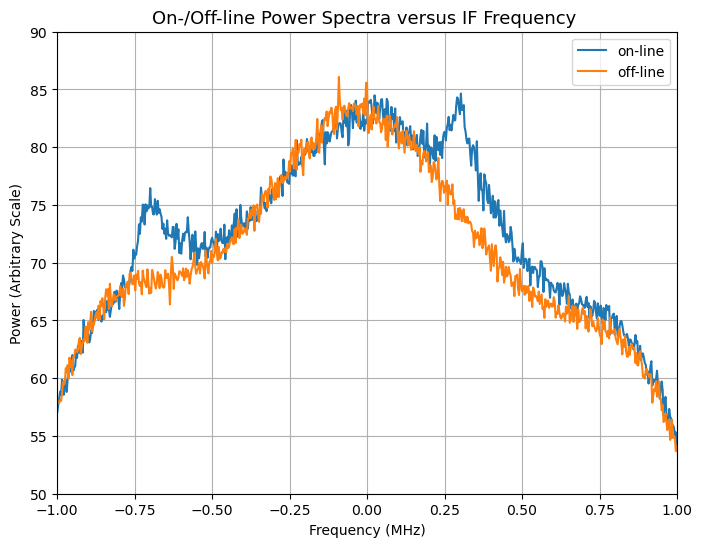

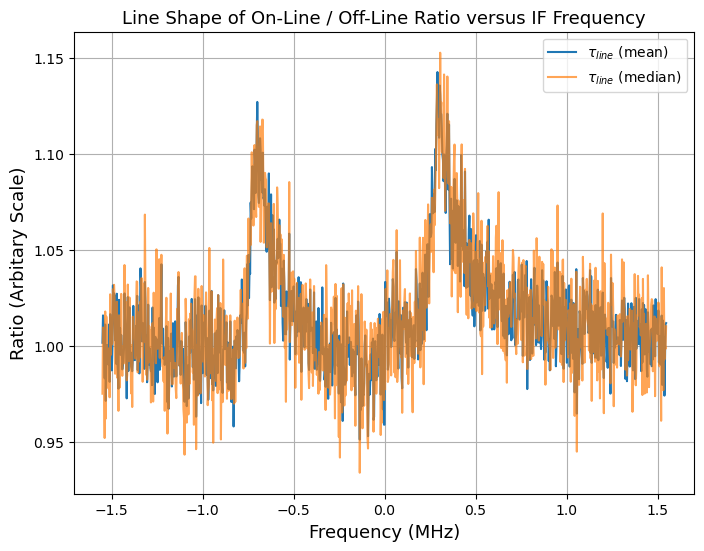

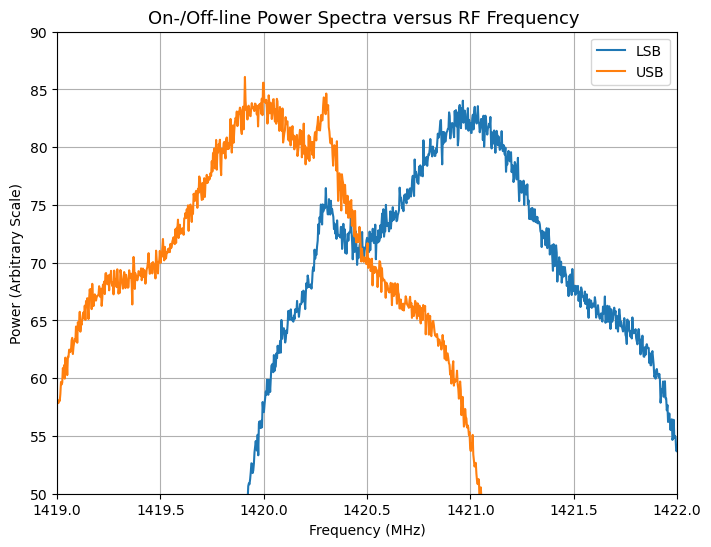

In [48]:
tau_mean, tau_median = graphAvgPowerSpectraLinesSingle(USB, LSB, sample_rate, xlim=(-1, 1), ylim=(50, 90))
graphTauLines(tau_mean, tau_median, sample_rate)
graphPowerSpectraRF(USB, LSB, sample_rate, xlim=(1419, 1422), ylim=(50, 90))

G = 127.366
Peak = 1420.285


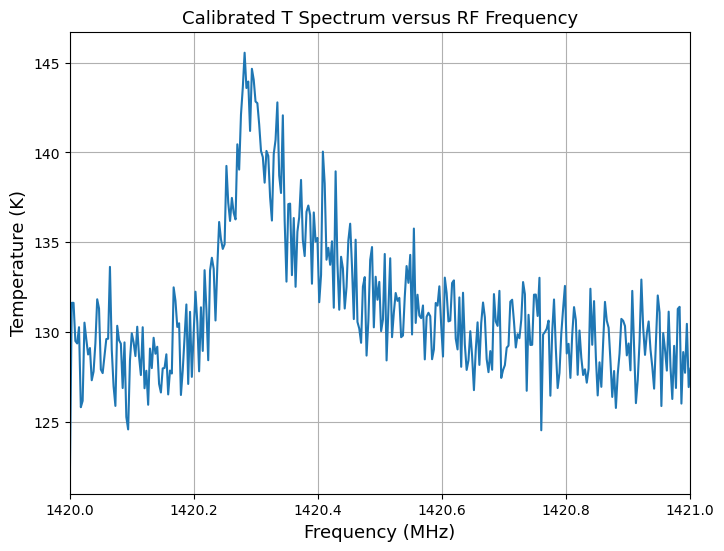

In [49]:
coldsky = getDataBlocks(data_coldsky)
humans = getDataBlocks(data_humans)

G = computeCalibratedGain(coldsky, humans, 300)
print(f"G = {round(G, 3)}")
T = tau_mean * G

clipped_T = T[len(T)//2:]
clipped_T.argmax()
print(f"Peak = {round(np.linspace(1420, 1421.5, len(clipped_T))[97], 3)}")

graphCalibratedT(T, xlim=(1420, 1421))
#graphCalibratedTDoppler(T, xlim=(-60, 60))

In [50]:
# Time Helper Functions
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, FK5, Galactic, ICRS, Angle
import astropy.units as units
from datetime import datetime

def pstToUTC(day, month, year, hour, min, sec):
    # Does not fully account for converting to next month 
    if hour + 8 >= 24:
        day += 1
        hour = hour + 8 - 24
    return datetime(year, month, day, hour, min, sec)

def formatTime(time_utc):
    return Time(str(datetime.strptime(str(time_utc), "%a %b %d %H:%M:%S %Y")), format="iso")

def horizontalToEquitorial(az, alt, time_utc, lat=37.873199, lon=-122.2573):
    location = EarthLocation(lat=lat*units.deg, lon=lon*units.deg)
    obstime = formatTime(time_utc)
    coord = AltAz(az=az*units.deg, alt=alt*units.deg, obstime=obstime, location=location)
    equitorial = coord.transform_to(ICRS())
    return equitorial.ra.deg, equitorial.dec.deg

def galacticToHorizontal(l, b, time_utc, lat=37.873199, lon=-122.2573):
    location = EarthLocation(lat=lat*units.deg, lon=lon*units.deg)
    obstime = formatTime(time_utc)
    galactic = Galactic(l=l*units.deg, b=b*units.deg)
    equitorial = galactic.transform_to(ICRS())
    horizontal = equitorial.transform_to(AltAz(obstime=obstime, location=location))
    return horizontal.az.deg, horizontal.alt.deg

In [58]:
time_utc = getUTC(data_coldsky)
print(f"jd = {getJulianDate(data_coldsky)}")
jd = 2460719.503247367
ra, dec = horizontalToEquitorial(0, 90, time_utc)

print(f"ra = {ra}")
print(f"dec = {dec}")
projected_v = ugradio.doppler.get_projected_velocity(ra, dec, jd)
#graphCalibratedTDoppler(T, projected_v, xlim=(-100, 80))

jd = 2460719.503247367
ra = 21.83769663821465
dec = 37.741002620506165


## 8

C:\Users\brand\AppData\Local\Temp\ipykernel_19548\1834783980.py:100: RuntimeWarning: invalid value encountered in divide
  tau_line_median = avg_on_median / avg_off_median


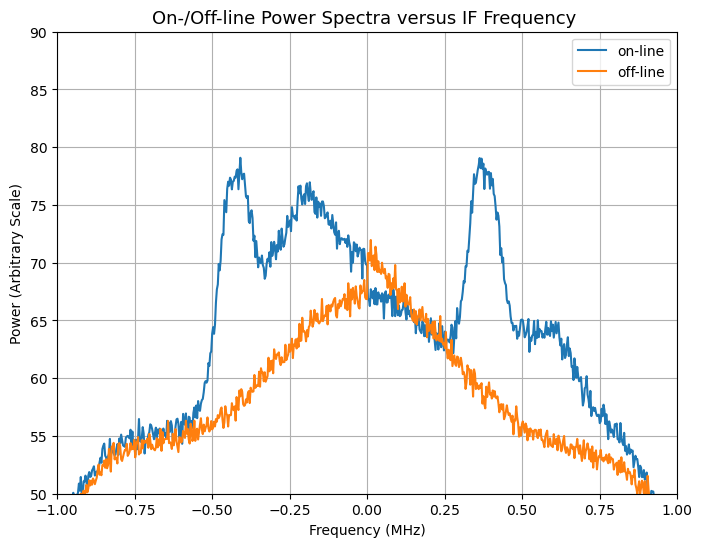

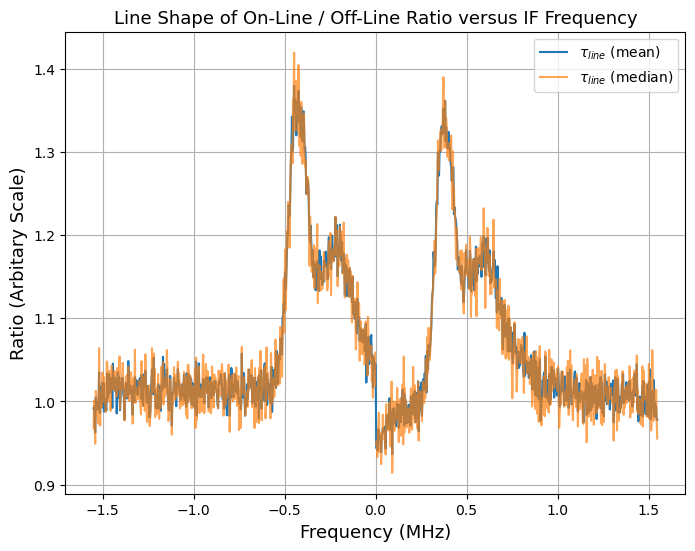

In [52]:
USB_aimed = getDataBlocks(data_USB_aimed)
LSB_aimed = getDataBlocks(data_LSB_aimed)
sample_rate = 3.1e6
center_freqs = ["1.42000 GHz", "1.42081 GHz"]

tau_mean, tau_median = graphAvgPowerSpectraLinesSingle(USB_aimed, LSB_aimed, sample_rate, xlim=(-1, 1), ylim=(50, 90))
graphTauLines(tau_mean, tau_median, sample_rate)

G = 127.366
T = tau_mean * G


In [53]:
print(f"jd = {getJulianDate(data_LSB_aimed)}")
time_utc = getUTC(data_LSB)
print(time_utc)
jd = 2460728.5492431596
az, alt = 298, 55
ra, dec = horizontalToEquitorial(az, alt, time_utc)
ra, dec = 6.450884 / 15, 62.725549
projected_v = ugradio.doppler.get_projected_velocity(ra, dec, jd)

jd = 2460728.5492431596
Wed Feb 12 23:44:19 2025


[amplitude, center, width]
gaussian1 params = [ 1.73763423e+01 -1.79975879e+04  2.28207963e+04]
gaussian2 params = [   39.67763487 20837.12839673 10974.10610392]


<Figure size 800x600 with 0 Axes>

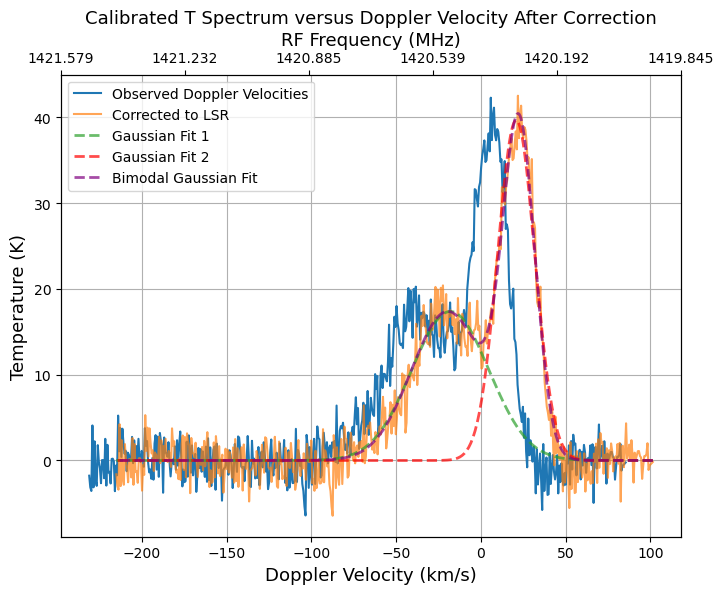

In [54]:
#graphCalibratedT(T, xlim=(1420, 1421))
graphCalibratedTDoppler2(T, projected_v)
#graphCalibratedTPolyfit(T, xlim=(1420, 1421.2))

[amplitude, center, width]
gaussian1 params = [4.11678908e+01 1.42037321e+03 5.03576928e-02]
gaussian2 params = [1.84442023e+01 1.42054904e+03 1.15512675e-01]


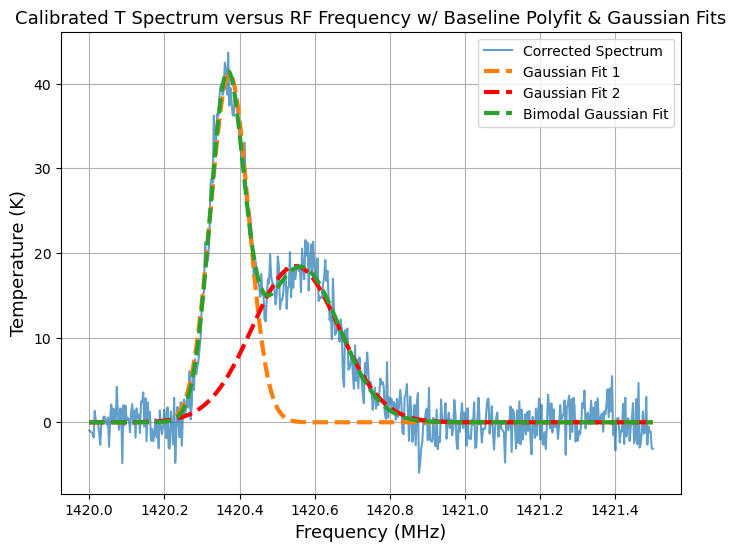

In [55]:
graphCalibratedPolyFitGaussian(T)

In [56]:
# Window of 0.00297 to 0.00298 to scale voltage counts
print(getTimes(1024)[921])
print(getTimes(1024)[925])

0.0002970967741935484
0.00029838709677419353


c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


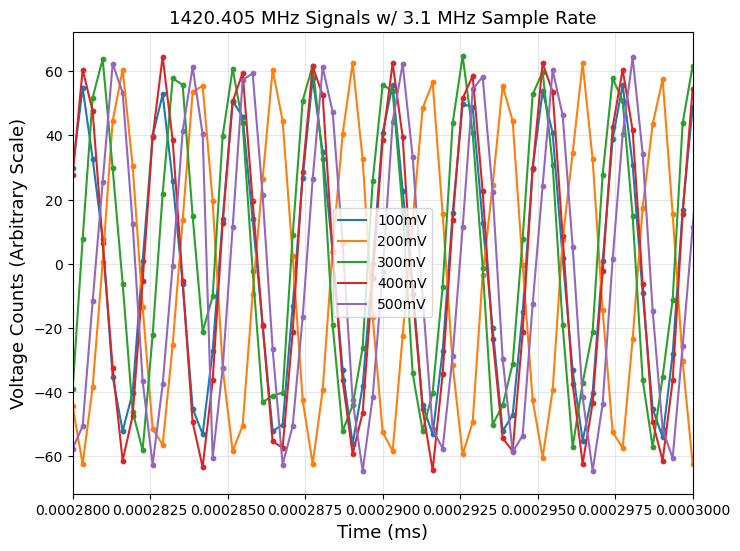

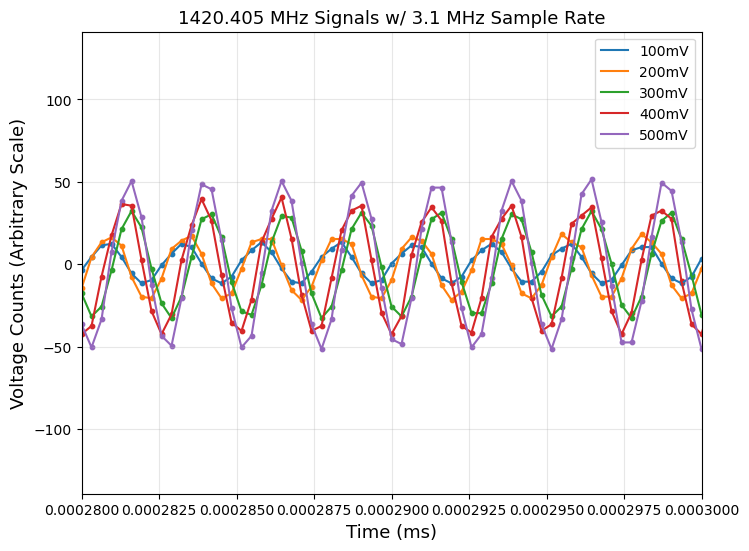

100mV max count = 56.333422847917454
200mV max count = 55.49769416521136
300mV max count = 60.65603542535593
400mV max count = 60.550234321184945
500mV max count = 64.78886429183561
100mV max count = 12.37648143956074
200mV max count = 19.81452852087214
300mV max count = 31.04680275296702
400mV max count = 39.72769394485215
500mV max count = 38.293133643562975


In [57]:
datasets = [data_100mV_short, data_200mV_short, data_300mV_short, data_400mV_short, data_500mV_short]
data = [getDataSingleBlock(i) for i in datasets]
labels = ["100mV", "200mV", "300mV", "400mV", "500mV"]

graphOverlayTimeData(data, labels, "1420.405 MHz", xlim=(0.00028, 0.0003))

datasets = [data_100mV_long, data_200mV_long, data_300mV_long, data_400mV_long, data_500mV_long]
data = [getDataSingleBlock(i) for i in datasets]
graphOverlayTimeData(data, labels, "1420.405 MHz", xlim=(0.00028, 0.0003))


# Window of 0.00297 to 0.00298 to scale voltage counts
datasets = [data_100mV_short, data_200mV_short, data_300mV_short, data_400mV_short, data_500mV_short]
datasets = [getDataSingleBlock(i) for i in datasets]
for i, data in enumerate(datasets):
    count = np.linalg.norm(max(data[921:926]))
    print(f"{labels[i]} max count = {count}")

datasets = [data_100mV_long, data_200mV_long, data_300mV_long, data_400mV_long, data_500mV_long]
datasets = [getDataSingleBlock(i) for i in datasets]
for i, data in enumerate(datasets):
    count = np.linalg.norm(max(data[921:926]))
    print(f"{labels[i]} max count = {count}")
